# Deconvolution Analysis (DANA)

In [1215]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [1216]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import time

In [1217]:
from dataclasses import dataclass

In [1218]:
import invisible_cities.core.system_of_units  as units
from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.io.dst_io    import load_dst
from invisible_cities.core.core_functions import in_range

In [1219]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [1220]:
from nextflex.core import Setup
from nextflex.core import KEY_sensor_fibres 
from nextflex.core import KEY_sensor_pmts   
from nextflex.core import S1_time           
from nextflex.core import SIPM_ids
from nextflex.core import get_sipm_postions
from nextflex.core import get_sensor_response

In [1221]:
from nextflex.graphics_reco   import plot_hits3d

In [1222]:
from  tics.stats_tics import bin_data_with_equal_bin_size
from tics.pd_tics   import get_index_slice_from_multi_index
from tics.util_tics   import find_nearest

In [1223]:
from nextflex.types import EventHits

In [1224]:
from nextflex.types import  ResponseSiPM
from nextflex.reco_functions import get_sipm_response
from nextflex.reco_functions import get_sipm_positions
from nextflex.reco_functions import get_event_sipm
from nextflex.reco_functions import get_sipm_event_hits

In [1225]:
from nextflex.graphics_reco   import plot_hits3d
from nextflex.graphics_reco   import plot_hits_projections
from nextflex.graphics_reco   import plot_hits_xy
from nextflex.graphics_reco   import bin_hits
from nextflex.graphics_reco   import bin_hits_xy

In [1226]:
from nextflex.tracks_dst import event_reco_hits

In [1227]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1228]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [1229]:
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from skimage.measure import label, regionprops
from skimage import data, util
from skimage.measure import label
from skimage.measure._regionprops import RegionProperties

In [1230]:
from nextflex.reco_image_functions import label_slice
from nextflex.reco_image_functions import select_slice_by_label

In [1378]:
from invisible_cities. reco.deconv_functions import deconvolution_input
from invisible_cities. reco.deconv_functions import richardson_lucy
from invisible_cities. reco.deconv_functions import deconvolve
from invisible_cities.cities.beersheba         import DeconvolutionMode
from invisible_cities.  reco.deconv_functions  import InterpolationMethod
from invisible_cities.cities.beersheba         import CutType
from invisible_cities.core.core_functions import shift_to_bin_centers

## Code

In [1231]:
def rebin_time(df : pd.DataFrame)->pd.Series:
        """
        takes the mean time and the energy sum

        """
        d = {}
        d['time'] = df['time'][0]
        d['charge'] = df['charge'].sum()
        return pd.Series(d)


## Setup

In [1232]:
FDATA = os.environ['FLEXDATA']
testDir  = os.path.join(FDATA,"testSetupData")
print(f"test dir = {testDir}")

test dir = /Users/jj/Development/flexdata/testSetupData


In [1233]:
setbb = Setup(flexDATA = testDir,
              tpConfig = "FLEX100_M6_O6.EL8bar.bb0nu")
print(setbb)


        Setup <FLEX100_M6_O6.EL8bar.bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar.bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu
        analysis directory           = /Users/jj/Development/flexdata/testSetupData/analysis/FLEX100_M6_O6.EL8bar.bb0nu
        number of h5 files in dir    = 1
        sipm map at                  = /Users/jj/Development/flexdata/testSetupData/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/testSetupData/kdsts/FLEX100_M6_O

In [1234]:
setbb.ifnames[0]

'/Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.53.next.h5'

In [1235]:
setbb.pitch

15.55

In [1236]:
setbb.mc_config()

,param_value
param_key,
num_events,4
TP_SiPM_binning,1.000000 mus
/Geometry/NextFlex/e_lifetime,1000. ms
/Geometry/NextFlex/el_gap_length,10. mm
/Geometry/NextFlex/el_field_int,16. kilovolt/cm
/Geometry/NextFlex/tp_teflon_thickness,6. mm
/Geometry/NextFlex/tp_teflon_hole_diam,6. mm
/Geometry/NextFlex/tp_sipm_sizeX,1.3 mm
/Geometry/NextFlex/tp_sipm_pitchX,15.55 mm


## SiPM Hits

##### Cutting at 10 pes

In [1237]:
start_time = time.perf_counter() 
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut = 10)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")                 

run time = 0.09043971099890769


In [1238]:
sipm_hits.df

,x,y,z,energy
0,-62.200001,-482.049988,787.0,13
1,-139.949997,-466.500000,764.0,17
2,-139.949997,-466.500000,769.0,12
3,-139.949997,-466.500000,781.0,13
4,-139.949997,-466.500000,784.0,19
...,...,...,...,...
799,-93.300003,-155.500000,904.0,27
800,-93.300003,-155.500000,905.0,19
801,-93.300003,-155.500000,906.0,11
802,-108.849998,-139.949997,902.0,13


#### Plot hits

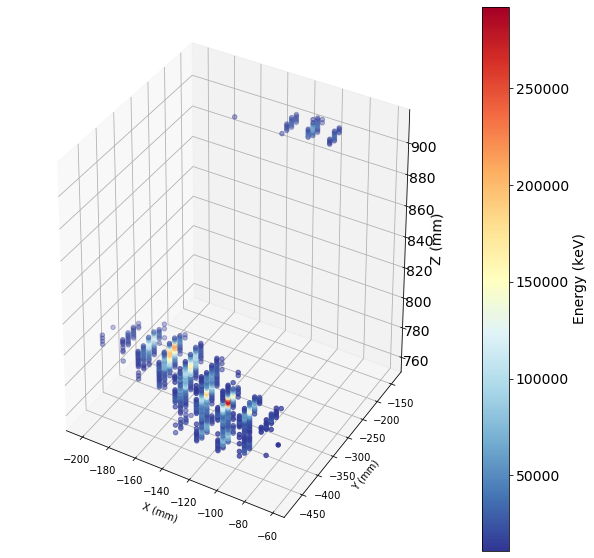

In [1239]:
plot_hits3d(sipm_hits,
                autorange = True,
                xrange    = (-500,500),
                yrange    = (-500,500),
                zrange    = (0,1000),
                figsize   = (10,10),
                fontsize  = 10)

In [1240]:
binHits = bin_hits(sipm_hits)

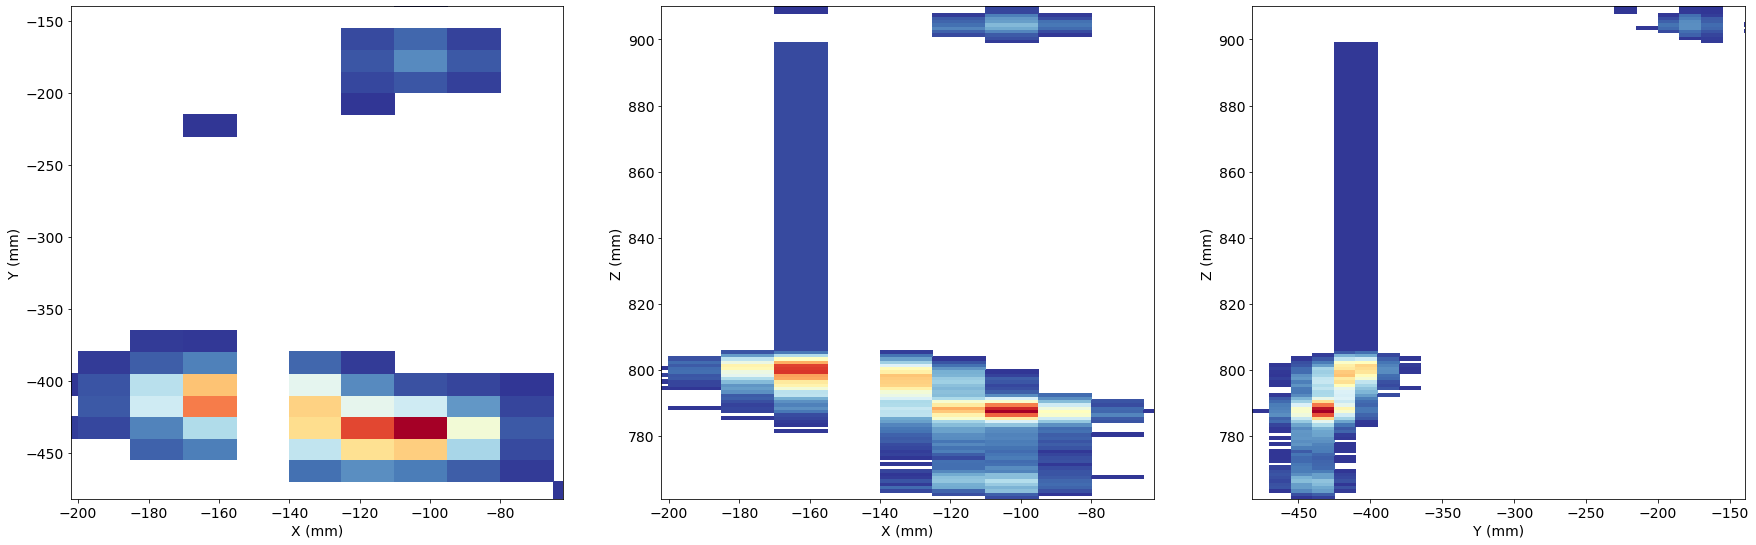

In [1241]:
plot_hits_projections(sipm_hits, binHits,  masked=True, figsize=(30, 10))

## Devonvolution

### Example with a single slice

#### Total and max energy

In [1343]:
etot = sipm_hits.df.energy.sum()
emax = sipm_hits.df.energy.max()
print(f" Total energy = {etot}, max energy = {emax}")

 Total energy = 32201, max energy = 292


#### Slicing in z 

In [979]:
zsl = np.unique(sipm_hits.df.z.values)
print(f"number of z slices = {len(zsl)}")

number of z slices = 57


In [1243]:
len_slices = [len(sipm_hits.df[sipm_hits.df.z == zs]) for zs in zsl]

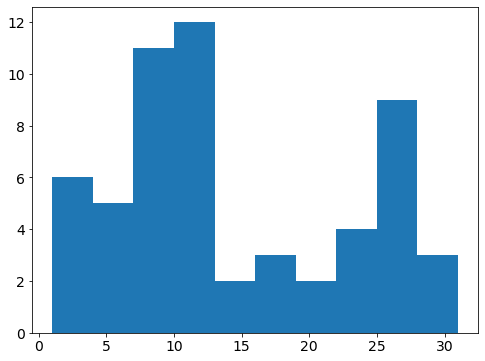

In [1244]:
_ = plt.hist(len_slices)

In [983]:
lmax = np.max(len_slices)
ilmax = np.argmax(len_slices)
print(f" length of slice (max) ={lmax}, i = {ilmax}")

 length of slice (max) =31, i = 27


#### Deconvolve longer slice

In [1310]:
dfzm = sipm_hits.df[sipm_hits.df.z == zsl[ilmax]].reset_index(drop=True)

In [1311]:
dfzm.head()

,x,y,z,energy
0,-139.949997,-466.5,788.0,22
1,-124.400002,-466.5,788.0,19
2,-108.849998,-466.5,788.0,26
3,-93.300003,-466.5,788.0,25
4,-77.750000,-466.5,788.0,14


In [1312]:
len(dfzm)

31

In [1313]:
dfzn = dfzm.copy()

In [1314]:
dfzn.head()

,x,y,z,energy
0,-139.949997,-466.5,788.0,22
1,-124.400002,-466.5,788.0,19
2,-108.849998,-466.5,788.0,26
3,-93.300003,-466.5,788.0,25
4,-77.750000,-466.5,788.0,14


In [1315]:
dfzn['energy'] = dfzn.energy / emax

In [1316]:
dfzn.energy.max()

0.9315068493150684

In [1317]:
dfzn.head()

,x,y,z,energy
0,-139.949997,-466.5,788.0,0.075342
1,-124.400002,-466.5,788.0,0.065068
2,-108.849998,-466.5,788.0,0.089041
3,-93.300003,-466.5,788.0,0.085616
4,-77.750000,-466.5,788.0,0.047945


In [1318]:
binHits = bin_hits_xy(dfzn)

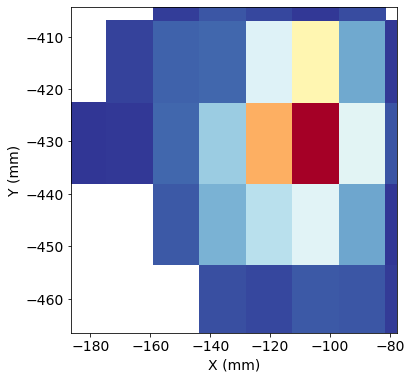

In [1338]:
plot_hits_xy(dfzn, binHits,  masked=True, figsize=(6, 6))

In [ ]:
bin_size      = (1., 1.)
sample_width  = (15.5, 15.5)
inter_method    = InterpolationMethod.cubic

In [1374]:
det_grid = [np.arange(dfzs[var].min() + bs/2, dfzs[var].max() - bs/2 + np.finfo(np.float32).eps, bs)
          for var, bs in zip(['x', 'y'], bin_size)]


In [1393]:
def image_from_df(df, det_grid, sample_width = (15.5, 15.5)):
    data = (df.x.values, df.y.values) 
    weight = df.energy.values
    ranges = [[coord.min() - 1.5 * sw, coord.max() + 1.5 * sw] \
              for coord, sw in zip(data, sample_width)]
      
    allbins = [grid[in_range(grid, *rang)] for rang, grid in zip(ranges, det_grid)]
    hs, edges = np.histogramdd(data, bins=allbins, normed=False, weights=weight)
    print(hs)
    image = np.meshgrid(*(shift_to_bin_centers(edge) for edge in edges), indexing='ij')
    print(image)
    image = tuple      (inter_p.flatten() for inter_p in image)
    return hs

In [1394]:
izn = image_from_df(dfzn, det_grid, sample_width = (15.5, 15.5))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[array([[-185.6000061, -185.6000061, -185.6000061, ..., -185.6000061,
        -185.6000061, -185.6000061],
       [-184.6000061, -184.6000061, -184.6000061, ..., -184.6000061,
        -184.6000061, -184.6000061],
       [-183.6000061, -183.6000061, -183.6000061, ..., -183.6000061,
        -183.6000061, -183.6000061],
       ...,
       [ -81.6000061,  -81.6000061,  -81.6000061, ...,  -81.6000061,
         -81.6000061,  -81.6000061],
       [ -80.6000061,  -80.6000061,  -80.6000061, ...,  -80.6000061,
         -80.6000061,  -80.6000061],
       [ -79.6000061,  -79.6000061,  -79.6000061, ...,  -79.6000061,
         -79.6000061,  -79.6000061]]), array([[-465.5, -464.5, -463.5, ..., -407.5, -406.5, -405.5],
       [-465.5, -464.5, -463.5, ..., -407.5, -406.5, -405.5],
       [-465.5, -464.5, -463.5, ..., -407.5, -406.5, -405.5],
       

In [1395]:
izn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1396]:
izn.shape

(107, 61)

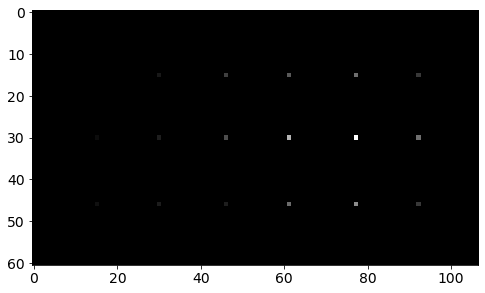

In [1398]:
plt.imshow(izn.T)

#### Labelling a slice in z and selecting by label

In [1327]:
sckl = label_slice(dfzn)

In [1328]:
sckl.lbl

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0]])

In [1329]:
sckl.fdf.head()

,x,y,z,energy
0,3,0,788.0,0.075342
1,4,0,788.0,0.065068
2,5,0,788.0,0.089041
3,6,0,788.0,0.085616
4,7,0,788.0,0.047945


In [1330]:
sckl.xl

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.]])

In [1332]:
sckl.xe * emax

array([[  0.,   0.,  11.,   0.,   0.],
       [  0.,   0.,  13.,  17.,   0.],
       [  0.,  26.,  32.,  30.,  15.],
       [ 22.,  67.,  82.,  32.,  25.],
       [ 19.,  96., 193., 114.,  19.],
       [ 26., 117., 272., 149.,  13.],
       [ 25.,  60., 118.,  61.,  21.],
       [ 14.,  12.,  24.,  13.,   0.]])

In [1333]:
sckl.prp[0]['intensity_image'] * emax

array([[  0.,   0.,  11.,   0.,   0.],
       [  0.,   0.,  13.,  17.,   0.],
       [  0.,  26.,  32.,  30.,  15.],
       [ 22.,  67.,  82.,  32.,  25.],
       [ 19.,  96., 193., 114.,  19.],
       [ 26., 117., 272., 149.,  13.],
       [ 25.,  60., 118.,  61.,  21.],
       [ 14.,  12.,  24.,  13.,   0.]])

In [1339]:
dfzs = select_slice_by_label(dfzn, sckl)

In [1340]:
dfzs.head()

,x,y,energy
0,-186.600006,-435.399994,0.037671
1,-171.050003,-435.399994,0.044521
2,-171.050003,-419.850006,0.058219
3,-108.849998,-466.500000,0.089041
4,-155.500000,-435.399994,0.109589


In [1336]:
xx = dfzs.x.mean()
xx

-124.90161378922001

In [1337]:
yy = dfzs.y.mean()
yy

-441.4193548387097

In [1341]:
zz = dfzn.z.values[0]

In [1342]:
zz

788.0

#### Interpolation 

In [1135]:
deconv_params     = dict(
  psf_fname       = '/Users/jj/Development/demoData/deconv/V3_PSF_dst_sum_collapsed.h5',                                                                                   
  e_cut           = 0.008,
  n_iterations    = 90,
  n_iterations_g  = 30,
  iteration_tol   = 0.00001,
  sample_width    = [15.5, 15.5],
  bin_size        = [ 1,  1],
  diffusion       = (1.072, 1.072, 0.3),
  deconv_mode     = DeconvolutionMode.joint,
  n_dim           = 2,
  cut_type        = CutType.abs,
  inter_method    = InterpolationMethod.cubic)



In [1136]:
deconv_params

{'psf_fname': '/Users/jj/Development/demoData/deconv/V3_PSF_dst_sum_collapsed.h5',
 'e_cut': 0.008,
 'n_iterations': 90,
 'n_iterations_g': 30,
 'iteration_tol': 1e-05,
 'sample_width': [15.5, 15.5],
 'bin_size': [1, 1],
 'diffusion': (1.072, 1.072, 0.3),
 'deconv_mode': <DeconvolutionMode.joint: 'joint'>,
 'n_dim': 2,
 'cut_type': <CutType.abs: 'abs'>,
 'inter_method': <InterpolationMethod.cubic: 'cubic'>}

In [1348]:
bin_size      = (1., 1.)
sample_width  = (15.5, 15.5)
inter_method    = InterpolationMethod.cubic

In [1372]:
det_grid = [np.arange(dfzs[var].min() + bs/2, dfzs[var].max() - bs/2 + np.finfo(np.float32).eps, bs)
          for var, bs in zip(['x', 'y'], bin_size)]


In [1373]:
det_grid

[array([-186.1000061, -185.1000061, -184.1000061, -183.1000061,
        -182.1000061, -181.1000061, -180.1000061, -179.1000061,
        -178.1000061, -177.1000061, -176.1000061, -175.1000061,
        -174.1000061, -173.1000061, -172.1000061, -171.1000061,
        -170.1000061, -169.1000061, -168.1000061, -167.1000061,
        -166.1000061, -165.1000061, -164.1000061, -163.1000061,
        -162.1000061, -161.1000061, -160.1000061, -159.1000061,
        -158.1000061, -157.1000061, -156.1000061, -155.1000061,
        -154.1000061, -153.1000061, -152.1000061, -151.1000061,
        -150.1000061, -149.1000061, -148.1000061, -147.1000061,
        -146.1000061, -145.1000061, -144.1000061, -143.1000061,
        -142.1000061, -141.1000061, -140.1000061, -139.1000061,
        -138.1000061, -137.1000061, -136.1000061, -135.1000061,
        -134.1000061, -133.1000061, -132.1000061, -131.1000061,
        -130.1000061, -129.1000061, -128.1000061, -127.1000061,
        -126.1000061, -125.1000061, -124

In [1349]:
interpolator = deconvolution_input(sample_width, 
                                   det_grid, 
                                   inter_method)

In [1350]:
inter_values, inter_pos = interpolator((dfzs.x.values, dfzs.y.values), dfzs.energy.values)

In [1410]:
len(inter_values.flatten())

6696

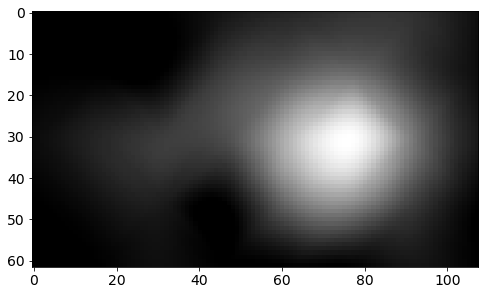

In [1401]:
plt.imshow(inter_values.T)

In [1408]:
inter_pos[0].shape

(6696,)

In [1352]:
dfzi = pd.DataFrame({'x' : inter_pos[0].flatten(), 
                     'y' : inter_pos[1].flatten(), 
                     'energy' : inter_values.flatten() })

In [1353]:
dfzi

,x,y,energy
0,-186.100006,-466.0,0.000000
1,-186.100006,-465.0,0.000000
2,-186.100006,-464.0,0.000000
3,-186.100006,-463.0,0.000000
4,-186.100006,-462.0,0.000000
...,...,...,...
6691,-79.100006,-409.0,0.000000
6692,-79.100006,-408.0,0.000082
6693,-79.100006,-407.0,0.001614
6694,-79.100006,-406.0,0.002851


In [1430]:
binHits = bin_hits_xy(dfzi,
            xr = (dfzi.x.min(), dfzi.x.max()),
            yr = (dfzi.y.min(), dfzi.y.max()),
            pitch = (1, 1))

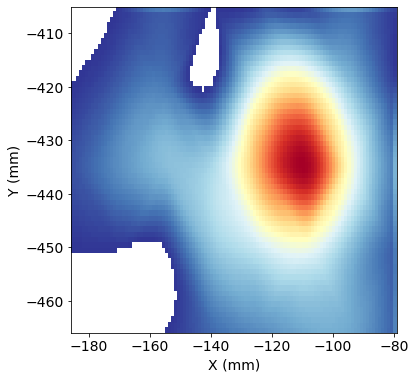

In [1431]:
plot_hits_xy(dfzi, binHits,  masked=True, figsize=(6, 6))

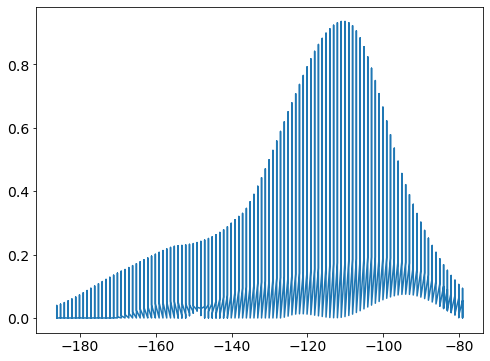

In [1356]:
plt.plot(dfzi.x, dfzi.energy)

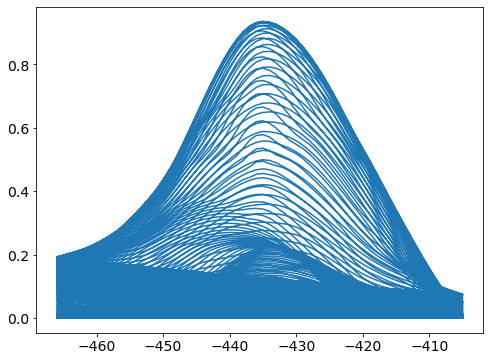

In [1357]:
plt.plot(dfzi.y, dfzi.energy)

#### PSF

In [1358]:
pspath = os.path.join(FDATA, "PSFs")
psfname = "PSF_flex_EL_diff.h5"
psfile = f"{pspath}/{psfname}"
print(f"PSF file = {psfile}")

PSF file = /Users/jj/Development/flexdata/PSFs/PSF_flex_EL_diff.h5


In [1359]:
psfs          = load_dst(psfile, 'PSF', 'PSFs')

In [1360]:
psfs.head()

,nevt,xr,yr,zr,x,y,z,factor
0,0,-99.5,-99.5,0.0,0.0,0.0,0.0,3.736639e-28
1,0,-99.5,-98.5,0.0,0.0,0.0,0.0,-8.002181e-28
2,0,-99.5,-97.5,0.0,0.0,0.0,0.0,-1.152425e-28
3,0,-99.5,-96.5,0.0,0.0,0.0,0.0,5.129082e-27
4,0,-99.5,-95.5,0.0,0.0,0.0,0.0,-1.475954e-26


In [1361]:
psf = psfs.loc[(psfs.z == find_nearest(psfs.z, zz)) &
               (psfs.x == find_nearest(psfs.x, xx)) &
               (psfs.y == find_nearest(psfs.y, yy)) , :]

In [1362]:
var_name     = np.array(['xr', 'yr', 'zr'])

In [1363]:
data = (dfzs.x.values, dfzs.y.values)

In [1364]:
columns       = var_name[:len(data)]

In [1365]:
psf_deco      = psf.factor.values.reshape(psf.loc[:, columns].nunique().values)

In [1366]:
psf_deco.shape

(200, 200)

In [1205]:
inter_signal = value

In [1206]:
inter_signal.shape

(108, 62)

In [1429]:
start_time = time.perf_counter() 
deconv_image  = np.nan_to_num(richardson_lucy(inter_values, psf_deco, 70, 1e-10))
                                                     
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f'LR from IC run in {run_time} seconds')

LR from IC run in 0.3546644210582599 seconds


In [ ]:
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=10)

In [1427]:
start_time = time.perf_counter() 
deconvolved_RL = restoration.richardson_lucy(inter_values, psf_deco, iterations=70)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 

In [1428]:
print(f'LR from scikit run in {run_time} seconds')

LR from scikit run in 0.3716569800162688 seconds


In [1368]:
deconv_image

array([[1.19504680e-72, 2.96743824e-70, 7.90954301e-68, ...,
        3.49110061e-51, 3.04588053e-53, 2.48805586e-55],
       [2.41401512e-71, 6.34474840e-69, 1.78962637e-66, ...,
        3.56009917e-49, 3.05967533e-51, 2.44576317e-53],
       [4.40476328e-70, 1.21500464e-67, 3.59552436e-65, ...,
        3.24146922e-47, 2.76655808e-49, 2.18169672e-51],
       ...,
       [7.55225910e-25, 1.57232561e-23, 2.55076979e-22, ...,
        1.94833771e-35, 5.94542717e-37, 1.52458712e-38],
       [2.76813158e-26, 5.68167108e-25, 9.10052585e-24, ...,
        4.19512116e-37, 1.30455518e-38, 3.42068427e-40],
       [8.01945409e-28, 1.62077733e-26, 2.56070475e-25, ...,
        7.35679951e-39, 2.33491439e-40, 6.27152622e-42]])

In [1386]:
deconv_image.T.shape

(62, 108)

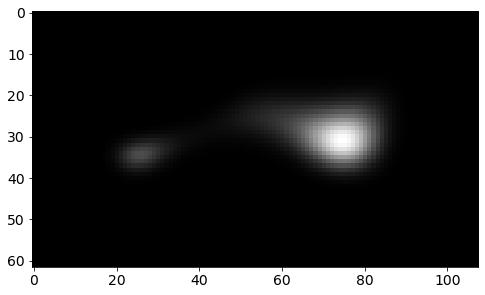

In [1369]:
plt.imshow(deconv_image.T)

In [1370]:
deconv_image.shape

(108, 62)

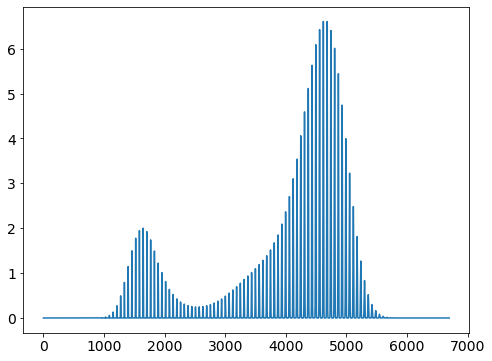

In [1371]:
plt.plot(deconv_image.flatten())

In [1412]:
dcdf = pd.DataFrame({"x" : inter_pos[0],
                     "y" : inter_pos[1],
                    "energy" : deconv_image.flatten()})

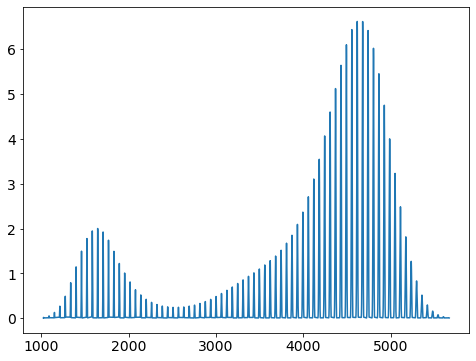

In [1417]:
plt.plot(dcdf.energy[dcdf.energy>0.01])

In [1418]:
dcdf = dcdf[dcdf.energy>0.01]

In [1421]:
binHits = bin_hits_xy(dcdf,
            xr = (dcdf.x.min(), dcdf.x.max()),
            yr = (dcdf.y.min(), dcdf.y.max()),
            pitch = (1, 1))

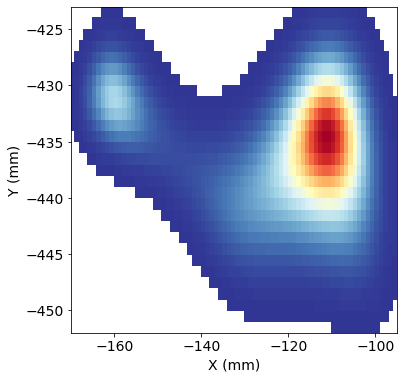

In [1422]:
plot_hits_xy(dcdf, binHits,  masked=True, figsize=(6, 6))

In [970]:
regions = regionprops(labels, xe)


In [971]:
len(regions)

1

In [972]:
regions[0]['centroid']

(1.2857142857142858, 1.5)

## Deconvolution

### Deconvolution example

In [117]:
astro = color.rgb2gray(data.astronaut())
psf = np.ones((5, 5)) / 25
astroc = conv2(astro, psf,'same')
astro_noisy = astroc.copy()
astro_noisy2 = astroc.copy()
astro_noisy  += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.
astro_noisy2 += 0.1 * astroc.std() * np.random.standard_normal(astroc.shape)


In [239]:
start_time = time.perf_counter() 
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=10)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 

print(f"run time = {run_time}")

run time = 0.2669327179901302


In [237]:
start_time = time.perf_counter() 
deconvolved_UW, _ = restoration.unsupervised_wiener(astro_noisy, psf)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")

run time = 0.5624630890088156


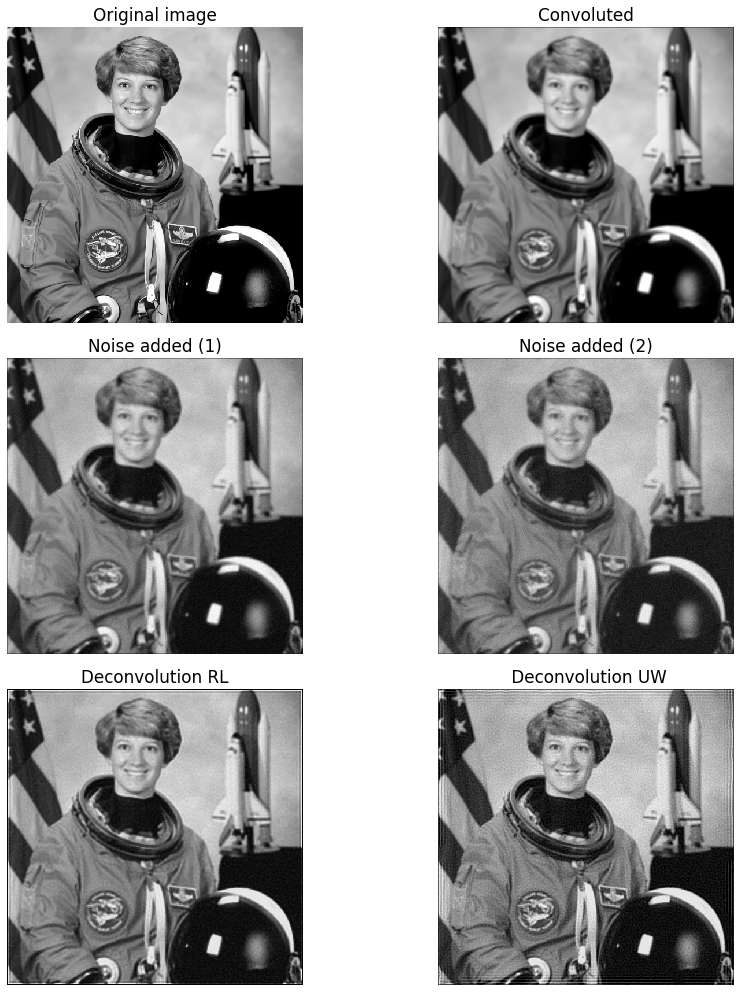

In [240]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 14),
                       sharex=True, sharey=True)
ax[0][0].imshow(astro)
ax[0][0].axis('off')
ax[0][0].set_title('Original image')

ax[0][1].imshow(astroc)
ax[0][1].axis('off')
ax[0][1].set_title('Convoluted')

ax[1][0].imshow(astro_noisy)
ax[1][0].axis('off')
ax[1][0].set_title('Noise added (1)')

ax[1][1].imshow(astro_noisy2)
ax[1][1].axis('off')
ax[1][1].set_title('Noise added (2)')

ax[2][0].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2][0].axis('off')
ax[2][0].set_title('Deconvolution RL')

ax[2][1].imshow(deconvolved_UW, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2][1].axis('off')
ax[2][1].set_title(' Deconvolution UW')
fig.tight_layout()
plt.show()